# **Project: Multitask Learning for Geometric Shape Classification and Counting**

## 1. Overview

In this project, you will design, implement, and evaluate a **multitask neural network** that performs **two tasks simultaneously**:

1. **Classification** – identify which pair of geometric shape types appears in a 28×28 binary image (135 possible configurations).
2. **Regression** – predict how many shapes of each type are present (6 regression targets).

This project focuses on **multi-task learning**, i.e., using one shared model to learn several related tasks at once. You will compare how adding an auxiliary task affects performance and training dynamics.

---

## 2. Dataset

You will use the **Geometric Shape Numbers (GSN)** dataset:

```bash
!wget https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
!unzip data_gsn.zip &> /dev/null
!rm data_gsn.zip
```

This will create a directory `data/` containing:

* **10,000 images** (28×28x1, grayscale)
* **labels.csv** – counts of each of six shape types per image

Each image contains exactly **two types** of geometric figures (out of six) and **10 shapes total**.

**Shape classes:**

| Index | Shape type     |
| ----: | -------------- |
|     0 | square         |
|     1 | circle         |
|     2 | triangle up    |
|     3 | triangle right |
|     4 | triangle down  |
|     5 | triangle left  |

Example row from `labels.csv`:

```
name,squares,circles,up,right,down,left
img_00000.png,0,0,0,4,0,6
```

Here, the image contains **4 right-pointing triangles** and **6 left-pointing triangles**.

**Split:**

* Training: first 9,000 samples
* Validation: last 1,000 samples

Examples:
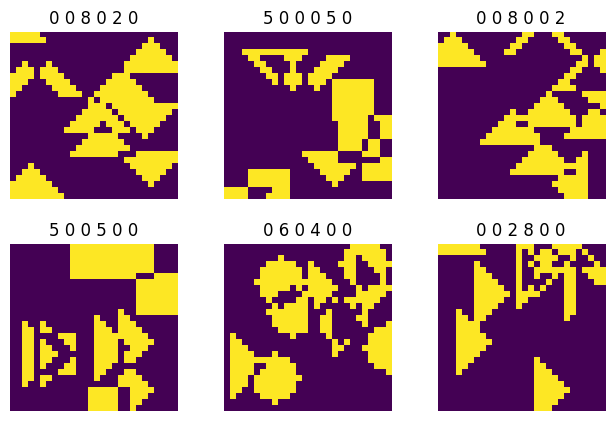

---

## 3. Tasks and objectives

You must design a **multitask deep learning system** that:

1. **Classifies** each image into one of **135 possible configurations**, representing:

   * which **two shape classes** appear, and
   * how their counts (1–9) sum to 10.

   → Example: "3 circles + 7 squares" is one configuration class.

2. **Regresses** the number of shapes of each type (a 6-dimensional real-valued output).

3. Combines both objectives in a **joint loss** function (Hint: losses are implemented in PyTorch):


$$ Loss = \text{NLLLoss(classification)} + \lambda_{\text{cnt}} \cdot \text{SmoothL1Loss(regression)}
$$

---

## 4. Model requirements

### Architecture constraints

You must use **exactly this feature extractor (backbone)**:

```python
nn.Sequential(
    nn.Conv2d(1, 8, 3, stride=1, padding=1), nn.ReLU(),
    nn.Conv2d(8, 16, 3, stride=1, padding=1), nn.ReLU(),
    nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU(),
    nn.Conv2d(32, 64, 3, stride=1, padding=1), nn.ReLU(),
    nn.Flatten(start_dim=1),
    nn.Linear(64 * 28 * 28, 256), nn.ReLU()
)
```

Then add **two separate heads**:

* `head_cls`: outputs log-probabilities for 135 classes
* `head_cnt`: outputs 6 regression values (counts)

The model must return two outputs: `(log_probs, counts)`.

You may add dropout or batch normalization inside the heads, **but you must not modify the backbone**.

---

## 5. Training setup

* Optimizer: **Adam**, learning rate = 1e-3
* Epochs: up to **100** (use **early stopping**)
* Batch sizes: **64** (train), **1000** (validation)
* Device: GPU allowed for Notebook, but your **final code must run on GPU within ~30 minutes**
* Random seed: set `torch.manual_seed(1)` for reproducibility
* Split: **exactly 9,000 train / 1,000 validation**


---

## 6. Data preprocessing and augmentation

You must implement a **PyTorch `Dataset` class** that:

* Reads `labels.csv`
* Loads the corresponding image (from `data/`)
* Returns both:
  * the image (as a tensor)
  * the labels (counts for 6 shapes)
* Optionally applies transformations

### Required augmentations

You must implement **at least three** of the following:

1. Random horizontal flip
2. Random vertical flip
3. Random 90° rotation (must correctly rotate orientation labels: up → right → down → left)
4. Random brightness/contrast (mild)
5. Gaussian noise
6. Random erasing (small areas only)


---

## 7. Evaluation metrics

Implement and report the following metrics on the validation set:

### (a) **Classification (135-way)**

* Top-1 accuracy
* Macro F1-score
* Per-pair accuracy (aggregate by unordered shape pair, e.g. {circle, up})

### (b) **Regression (6-D counts)**

* RMSE per class and overall
* MAE per class and overall

Also plot:

* Training and validation losses
* Validation accuracy and RMSE over epochs

**Important**: This task is not about finding the best architecture; we expect at least 50% accuracy, but achieving results higher than that will not affect the grade for the assignment**.


---

## 8. Experiments and analysis

You must train and compare **three model settings**:

| Setting | Description                                      |
| :------ | :----------------------------------------------- |
| 1       | **Classification-only:** λ_cnt = 0               |
| 2       | **Regression-only:** classification loss ignored |
| 3       | **Multitask:** λ_cnt = with your choose          |

For each experiment:

* Train until early stopping
* Record loss, accuracy, RMSE, and runtime
* Compare results and explain how λ influences learning
* Discuss whether multitask learning improves the main tasks


---

## 9. Final deliverables

You must submit .zip project with:

1. **Code** (`.ipynb` or `.py`) that:

   * Downloads and extracts the dataset
   * Defines dataset, dataloaders, model, loss, training loop, evaluation, and plotting
   * Can run start-to-end without interaction, and finishes within 30 minutes on Colab T4 GPUs
   * Includes three experiment configurations

2. **Report (2–4 pages, PDF)** including:
   * Section on (EDA) Exploratory Data Analysis in your report: no more than 3 graphs or tables describing the data set.
   * Model architecture
   * Description and justification of augmentations
   * Results table (loss, accuracy, RMSE for all runs)
   * Learning curves
   * Discussion on multitask effects

3. **README.md**:

   * Link to Colab version of task for fast replication.
   * Approximate runtime and resource requirements

---

## 10. Grading rubric

Component	Description	Points
1. Implementation correctness	Correct use of the fixed backbone, two-headed model, and proper training loop (classification + regression).	30%
2. Data & augmentations	Proper dataset loading, preprocessing, and at least three augmentations with brief justification.	20%
3. Evaluation & experiments	Correct computation of metrics (accuracy, F1, RMSE) and completion of all three λ configurations (λ=0, regression-only, your choice λ).	30%
4. Report & analysis
A clear separation of concerns (e.g. headers in notebooks, modules in code) and concise 2–4 page report with results tables, learning curves, confusion matrix, and short discussion on multitask effects and error examples.
20%

###### Readability and modularity will be considered within each grading component. Clear structure (headers in notebooks, docstrings, modular code) significantly improves evaluation speed. Emphasize using clear headers to help reviewers navigate efficiently.
---

In [1]:
!wget  https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
!unzip data_gsn.zip &> /dev/null
!rm data_gsn.zip

--2025-11-24 11:18:42--  https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/marcin119a/data/refs/heads/main/data_gsn.zip [following]
--2025-11-24 11:18:42--  https://raw.githubusercontent.com/marcin119a/data/refs/heads/main/data_gsn.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5544261 (5.3M) [application/zip]
Saving to: ‘data_gsn.zip’

data_gsn.zip        100%[===================>]   5.29M  --.-KB/s    in 0.04s   

2025-11-24 11:18:43 (132 MB/s) - ‘data_gsn.zip’ saved [5544261/5544261]



In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error

# Set random seeds for reproducibility
def set_seed(seed=1):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(1)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
class GSNDataset(Dataset):
    def __init__(self, root_dir, csv_file, split='train', transform=None):
        """
        Args:
            root_dir (str): Directory with all the images.
            csv_file (str): Path to the csv file with annotations.
            split (str): 'train' (first 9000) or 'val' (last 1000).
            transform (bool): Whether to apply random augmentations.
        """
        self.root_dir = root_dir
        self.data = pd.read_csv(csv_file)

        # Split dataset: first 9000 for train, last 1000 for val
        if split == 'train':
            self.data = self.data.iloc[:9000].reset_index(drop=True)
        else:
            self.data = self.data.iloc[9000:].reset_index(drop=True)

        self.transform = transform
        self.shape_names = ['squares', 'circles', 'up', 'right', 'down', 'left']

        # Pre-compute class mapping logic
        # Generate all unique pairs of indices (i, j) where i < j
        self.pairs = []
        for i in range(6):
            for j in range(i + 1, 6):
                self.pairs.append((i, j))

    def _get_class_id(self, counts):
        """
        Maps the 6-dimensional count vector to a class ID (0-134).
        Logic: Find the two non-zero shapes (i, j).
        Class is determined by the pair index and the count of the first shape.
        """
        indices = np.nonzero(counts)[0]
        if len(indices) != 2:
            # Fallback for unexpected data, though dataset guarantees exactly 2 types
            return 0

        idx1, idx2 = indices[0], indices[1] # idx1 is always < idx2 because numpy returns sorted

        # Find which pair number this is (0 to 14)
        pair_idx = self.pairs.index((idx1, idx2))

        # Calculate offset based on the count of the first shape (1-9)
        # range 1-9 maps to 0-8
        count_offset = int(counts[idx1]) - 1

        # Total class ID
        return pair_idx * 9 + count_offset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('L') # Load as grayscale

        # Get counts as numpy array
        counts = self.data.iloc[idx, 1:].values.astype(np.float32)

        # Apply Augmentations manually to handle label dependencies
        if self.transform:
            # 1. Random Horizontal Flip
            if random.random() > 0.5:
                image = transforms.functional.hflip(image)
                # Horizontal flip swaps: Right (3) <-> Left (5)
                counts[3], counts[5] = counts[5], counts[3]

            # 2. Random Vertical Flip
            if random.random() > 0.5:
                image = transforms.functional.vflip(image)
                # Vertical flip swaps: Up (2) <-> Down (4)
                counts[2], counts[4] = counts[4], counts[2]

            # 3. Random 90 Degree Rotation (Clockwise)
            # Options: 0, 90, 180, 270
            k = random.randint(0, 3)
            if k > 0:
                # Rotate image k * 90 degrees clockwise
                # TF.rotate expects degrees counter-clockwise. -90 is 90 clockwise.
                angle = -90 * k
                image = transforms.functional.rotate(image, angle)

                # Rotate labels k times: Up(2)->Right(3)->Down(4)->Left(5)->Up(2)
                # Indices: 2, 3, 4, 5
                sub_counts = [counts[2], counts[3], counts[4], counts[5]]
                # Shift array right by k steps
                # If k=1 (90 deg): Up(idx 0) moves to Right(idx 1)
                shifted = np.roll(sub_counts, k)
                counts[2], counts[3], counts[4], counts[5] = shifted

            # 4. Random Brightness (Mild)
            if random.random() > 0.5:
                image = transforms.ColorJitter(brightness=0.2)(image)

            # Convert to Tensor
            image = transforms.functional.to_tensor(image)

            # 5. Gaussian Noise
            if random.random() > 0.5:
                noise = torch.randn_like(image) * 0.05
                image = image + noise
                image = torch.clamp(image, 0, 1)

            # 6. Random Erasing
            if random.random() > 0.5:
                # Use pytorch's random erasing
                eraser = transforms.RandomErasing(p=1, scale=(0.02, 0.1))
                image = eraser(image)

        else:
            image = transforms.functional.to_tensor(image)

        # Get Classification Label (computed AFTER augmentation, though counts define the class)
        # Note: Transformations like rotation might change which shape is 'Up',
        # potentially changing the class ID if the pair or counts shift.
        class_label = self._get_class_id(counts)

        return image, torch.tensor(class_label, dtype=torch.long), torch.from_numpy(counts)

# Create DataLoaders
train_dataset = GSNDataset('data/', 'data/labels.csv', split='train', transform=True)
val_dataset = GSNDataset('data/', 'data/labels.csv', split='val', transform=False)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)

In [4]:
class MultitaskNetwork(nn.Module):
    def __init__(self):
        super(MultitaskNetwork, self).__init__()

        # Fixed Backbone (Feature Extractor) - DO NOT MODIFY
        self.backbone = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=1, padding=1), nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(64 * 28 * 28, 256), nn.ReLU()
        )

        # Head 1: Classification (135 classes)
        self.head_cls = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 135) # Output logits (log-probs handled by CrossEntropy/NLL)
        )

        # Head 2: Regression (6 counts)
        self.head_cnt = nn.Sequential(
            nn.Linear(256, 6) # Output raw counts
        )

    def forward(self, x):
        features = self.backbone(x)

        # Classification output (LogSoftmax for NLLLoss)
        cls_logits = self.head_cls(features)
        cls_log_probs = F.log_softmax(cls_logits, dim=1)

        # Regression output
        cnt_preds = self.head_cnt(features)

        return cls_log_probs, cnt_preds

In [5]:
def train_experiment(setting_name, lambda_cnt, ignore_cls=False):
    """
    Runs a full training loop for a specific experiment setting.

    Args:
        setting_name (str): Name of the experiment.
        lambda_cnt (float): Weight for the regression loss.
        ignore_cls (bool): If True, sets classification loss to 0 (Regression Only).
    """
    print(f"\n--- Starting Experiment: {setting_name} ---")

    model = MultitaskNetwork().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Loss functions
    criterion_cls = nn.NLLLoss()
    criterion_cnt = nn.SmoothL1Loss()

    # History tracking
    history = {
        'train_loss': [], 'val_loss': [],
        'val_acc': [], 'val_rmse': []
    }

    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0

    epochs = 100

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels_cls, labels_cnt in train_loader:
            images = images.to(device)
            labels_cls = labels_cls.to(device)
            labels_cnt = labels_cnt.to(device)

            optimizer.zero_grad()

            # Forward pass
            log_probs, counts_pred = model(images)

            # Calculate losses based on settings
            loss_cls = criterion_cls(log_probs, labels_cls)
            loss_cnt = criterion_cnt(counts_pred, labels_cnt)

            if ignore_cls:
                loss = lambda_cnt * loss_cnt
            else:
                loss = loss_cls + lambda_cnt * loss_cnt

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_preds_cnt = []
        all_labels_cnt = []

        with torch.no_grad():
            for images, labels_cls, labels_cnt in val_loader:
                images = images.to(device)
                labels_cls = labels_cls.to(device)
                labels_cnt = labels_cnt.to(device)

                log_probs, counts_pred = model(images)

                # Validation Loss
                l_cls = criterion_cls(log_probs, labels_cls)
                l_cnt = criterion_cnt(counts_pred, labels_cnt)

                if ignore_cls:
                    total_l = lambda_cnt * l_cnt
                else:
                    total_l = l_cls + lambda_cnt * l_cnt

                val_loss += total_l.item()

                # Metrics: Accuracy
                _, predicted = torch.max(log_probs.data, 1)
                total += labels_cls.size(0)
                correct += (predicted == labels_cls).sum().item()

                # Metrics: Accumulate for RMSE
                all_preds_cnt.append(counts_pred.cpu())
                all_labels_cnt.append(labels_cnt.cpu())

        # Aggregation
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total

        all_preds_cnt = torch.cat(all_preds_cnt).numpy()
        all_labels_cnt = torch.cat(all_labels_cnt).numpy()
        val_rmse = np.sqrt(mean_squared_error(all_labels_cnt, all_preds_cnt))

        # Update history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)
        history['val_rmse'].append(val_rmse)

        print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}% | Val RMSE: {val_rmse:.4f}")

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save best model state if needed
            torch.save(model.state_dict(), f'best_model_{setting_name}.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    return history, model

# Helper to evaluate comprehensive metrics for the final report
def evaluate_final_metrics(model):
    model.eval()
    all_preds_cls = []
    all_labels_cls = []
    all_preds_cnt = []
    all_labels_cnt = []

    with torch.no_grad():
        for images, labels_cls, labels_cnt in val_loader:
            images = images.to(device)
            log_probs, counts_pred = model(images)

            _, predicted = torch.max(log_probs.data, 1)

            all_preds_cls.extend(predicted.cpu().numpy())
            all_labels_cls.extend(labels_cls.numpy())
            all_preds_cnt.append(counts_pred.cpu())
            all_labels_cnt.append(labels_cnt.cpu())

    all_preds_cnt = torch.cat(all_preds_cnt).numpy()
    all_labels_cnt = torch.cat(all_labels_cnt).numpy()

    # 1. Classification Metrics
    acc = np.mean(np.array(all_preds_cls) == np.array(all_labels_cls))
    f1 = f1_score(all_labels_cls, all_preds_cls, average='macro')

    # 2. Regression Metrics
    mse = mean_squared_error(all_labels_cnt, all_preds_cnt)
    rmse_overall = np.sqrt(mse)
    mae_overall = mean_absolute_error(all_labels_cnt, all_preds_cnt)

    print(f"\nFinal Evaluation:")
    print(f"Top-1 Accuracy: {acc*100:.2f}%")
    print(f"Macro F1-Score: {f1:.4f}")
    print(f"Overall RMSE: {rmse_overall:.4f}")
    print(f"Overall MAE: {mae_overall:.4f}")

    return acc, rmse_overall

In [6]:
# Experiment 1: Classification Only (lambda = 0)
hist_1, model_1 = train_experiment("Classification_Only", lambda_cnt=0.0)

# Experiment 2: Regression Only (ignore classification loss)
# lambda acts as a scaler, we set it to 1.0 for the regression loss weight
hist_2, model_2 = train_experiment("Regression_Only", lambda_cnt=1.0, ignore_cls=True)

# Experiment 3: Multitask (lambda = 1.0)
hist_3, model_3 = train_experiment("Multitask", lambda_cnt=1.0)


--- Starting Experiment: Classification_Only ---
Epoch [1/100] Loss: 4.7505 | Val Loss: 4.6828 | Val Acc: 0.80% | Val RMSE: 3.1260
Epoch [2/100] Loss: 4.6802 | Val Loss: 4.5876 | Val Acc: 2.20% | Val RMSE: 3.1104
Epoch [3/100] Loss: 4.1795 | Val Loss: 3.4751 | Val Acc: 8.30% | Val RMSE: 3.1733
Epoch [4/100] Loss: 3.4146 | Val Loss: 2.9901 | Val Acc: 11.90% | Val RMSE: 3.3018
Epoch [5/100] Loss: 2.9478 | Val Loss: 2.5189 | Val Acc: 17.70% | Val RMSE: 3.4020
Epoch [6/100] Loss: 2.6706 | Val Loss: 2.2505 | Val Acc: 23.60% | Val RMSE: 3.4674
Epoch [7/100] Loss: 2.4612 | Val Loss: 1.9651 | Val Acc: 27.70% | Val RMSE: 3.5421
Epoch [8/100] Loss: 2.2404 | Val Loss: 1.8380 | Val Acc: 32.20% | Val RMSE: 3.5625
Epoch [9/100] Loss: 2.1362 | Val Loss: 1.7417 | Val Acc: 33.90% | Val RMSE: 3.5736
Epoch [10/100] Loss: 2.0224 | Val Loss: 1.7744 | Val Acc: 30.30% | Val RMSE: 3.6078
Epoch [11/100] Loss: 1.9713 | Val Loss: 1.6105 | Val Acc: 34.70% | Val RMSE: 3.6978
Epoch [12/100] Loss: 1.8900 | Val Loss